Analysis Dataset

In [1]:
from datasets import load_dataset
import pandas as pd
import re

c:\Code\Code_Semantic_Search\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Load dataset and convert to dataframe
ds = load_dataset("code_search_net", "python", trust_remote_code=True)
df = ds['train'].to_pandas()

# Retrieve necessary data series.
df = df[['func_name', 'func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens']]

datasets.dataset_dict.DatasetDict

In [3]:
# Number of data in each set
ds.num_rows

{'train': 412178, 'test': 22176, 'validation': 23107}

In [4]:
# Count the length of code token and docstring token
df['func_code_tokens_len'] = df['func_code_tokens'].apply(lambda x: len(x))
df['func_documentation_tokens_len'] = df['func_documentation_tokens'].apply(lambda x: len(x))

df['func_code_tokens_len'].describe(), df['func_documentation_tokens_len'].describe()

# There are chinese documentation...
df.loc[df['func_documentation_tokens_len'] == 1].head()

,func_name,func_code_string,func_code_tokens,func_documentation_string,func_documentation_tokens,func_code_tokens_len,func_documentation_tokens_len
10978,WechatSogouAPI.__hosting_wechat_img,"def __hosting_wechat_img(self, content_info, h...","[def, __hosting_wechat_img, (, self, ,, conten...",将微信明细中图片托管到云端，同时将html页面中的对应图片替换\n\n Par...,[将微信明细中图片托管到云端，同时将html页面中的对应图片替换],83,1
10984,WechatSogouAPI.get_article_content,"def get_article_content(self, url, del_qqmusic...","[def, get_article_content, (, self, ,, url, ,,...",获取文章原文，避免临时链接失效\n\n Parameters\n ...,[获取文章原文，避免临时链接失效],116,1
10985,WechatSogouAPI.get_sugg,"def get_sugg(self, keyword):\n """"""获取微信搜...","[def, get_sugg, (, self, ,, keyword, ), :, url...",获取微信搜狗搜索关键词联想\n\n Parameters\n -...,[获取微信搜狗搜索关键词联想],71,1
10986,unlock_sogou_callback_example,"def unlock_sogou_callback_example(url, req, re...","[def, unlock_sogou_callback_example, (, url, ,...",手动打码解锁\n\n Parameters\n ----------\n ...,[手动打码解锁],112,1
10987,unlock_weixin_callback_example,"def unlock_weixin_callback_example(url, req, r...","[def, unlock_weixin_callback_example, (, url, ...",手动打码解锁\n\n Parameters\n ----------\n ...,[手动打码解锁],97,1


In [5]:
def _filter_dataset(ds, min_doc_token: int, max_doc_token: int, min_code_token: int, max_code_token: int, language='python') -> bool:
    # Step 1: Only allow python
    if ds['language'] != language:
        return False
    
    # Step 2: Check if the coden token length if > min_code_token
    if len(ds['func_code_tokens']) < min_code_token or \
        len(ds['func_code_tokens']) > max_code_token:
        return False
    
    if len(ds['func_documentation_tokens']) < min_doc_token or \
        len(ds['func_documentation_tokens']) > max_doc_token:
        return False
    
    # Step 3: Check if the func documentation only include ascii code (exclude non-english).
    if ds['func_documentation_string'].isascii() == False:
        return False

    return True

def _filter_columns_from_dataset(datasets, columns_to_save: list):

    # Get all the columns names
    dataset_columns_to_remove = {
        dataset: columns for dataset, columns in datasets.column_names.items()
    }

    # Remove columns to save from all the column names
    for dataset in dataset_columns_to_remove:
        for column in columns_to_save:
            if column in dataset_columns_to_remove[dataset]:
                dataset_columns_to_remove[dataset].remove(column)

    # Remove all the columns except columns_to_save.
    for dataset in datasets:
        datasets[dataset] = datasets[dataset].remove_columns(dataset_columns_to_remove[dataset])
    
    return datasets

columns_to_save = [
        'func_code_string',
        'func_code_tokens',
        'func_documentation_string',
        'func_documentation_tokens'
    ]

filtered_ds = ds.filter(lambda example: _filter_dataset(example, 0, 64, 0, 64))
filtered_ds = _filter_columns_from_dataset(ds, columns_to_save)

In [10]:
import unicodedata

def _unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def _normalize_string(s):
    s = _unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

def preprocess_documentation_string_to_tokens(s):
    return _normalize_string(s).split()

filtered_ds = filtered_ds.map(
    lambda example: {
        'func_documentation_tokens': preprocess_documentation_string_to_tokens(example['func_documentation_string'])
    }
)

Map: 100%|██████████| 23107/23107 [00:02<00:00, 10287.69 examples/s]


In [11]:
filtered_pd = filtered_ds['train'].to_pandas()
filtered_pd.head()

,func_code_string,func_code_tokens,func_documentation_string,func_documentation_tokens
0,"def train(train_dir, model_save_path=None, n_n...","[def, train, (, train_dir, ,, model_save_path,...",Trains a k-nearest neighbors classifier for fa...,"[trains, a, k, nearest, neighbors, classifier,..."
1,"def predict(X_img_path, knn_clf=None, model_pa...","[def, predict, (, X_img_path, ,, knn_clf, =, N...",Recognizes faces in given image using a traine...,"[recognizes, faces, in, given, image, using, a..."
2,"def show_prediction_labels_on_image(img_path, ...","[def, show_prediction_labels_on_image, (, img_...",Shows the face recognition results visually.\n...,"[shows, the, face, recognition, results, visua..."
3,"def _rect_to_css(rect):\n """"""\n Convert ...","[def, _rect_to_css, (, rect, ), :, return, rec...",Convert a dlib 'rect' object to a plain tuple ...,"[convert, a, dlib, rect, object, to, a, plain,..."
4,"def _trim_css_to_bounds(css, image_shape):\n ...","[def, _trim_css_to_bounds, (, css, ,, image_sh...","Make sure a tuple in (top, right, bottom, left...","[make, sure, a, tuple, in, top, right, bottom,..."


In [7]:
import sys
sys.path.append(r'C:\Code\Code_Semantic_Search')

from data.tokenizer import Tokenizer
code_tokenizer = Tokenizer(8192)
doc_tokenizer = Tokenizer(8192)

# Load tokens in tokenizer
code_tokenizer.load_datasets(filtered_ds, 'func_code_tokens')
doc_tokenizer.load_datasets(filtered_ds, 'func_documentation_tokens')
print(f'code tokens: {len(code_tokenizer)}')
print(f'doc tokens: {len(doc_tokenizer)}')


code tokens: 8192
doc tokens: 8192


In [8]:
# filter the dataset to only include allow code tokens and allow documentation tokens
# so that the dataset will not have any unknown token
def _filter_tokens(ds, allow_code_tokens, allow_doc_tokens) -> bool:
    for code_token, doc_token in zip(ds['func_code_tokens'], ds['func_documentation_tokens']):
        if code_token not in allow_code_tokens:
            return False

        if doc_token not in allow_doc_tokens:
            return False

    return True


filtered_tokens = filtered_ds.filter(lambda example: _filter_tokens(example, code_tokenizer.most_freq_tokens, doc_tokenizer.most_freq_tokens))


Filter: 100%|██████████| 23107/23107 [00:03<00:00, 7561.67 examples/s]


In [14]:
len(filtered_tokens['train']), len(filtered_tokens['test']), len(filtered_tokens['validation'])

(37671, 2049, 2401)

# Examine documentation classes for applying class weighting

In [16]:
import sys
import pandas as pd
sys.path.append(r'C:\Code\Code_Semantic_Search')

from pathlib import Path
from data.dataset import get_datasets
from data.tokenizer import Tokenizer

# Configure hyperparameters
input_size = 8192
output_size = 8192
batch_size = 64
hidden_size = 256
sequence_length = 128
dropout_p = 0.3
weight_decay = 1e-5
learning_rate = 5e-4
label_smoothing = 0.1

# Get datasets
DATASET_LOCAL_PATH = Path(r'C:\Code\Code_Semantic_Search\preprocessed_dataset')
code_tokenizer = Tokenizer(input_size)
doc_tokenizer = Tokenizer(output_size)
train_dataset, test_dataset, validation_dataset = get_datasets(data_local_path=DATASET_LOCAL_PATH,
                                                    code_tokenizer=code_tokenizer,
                                                    doc_tokenizer=doc_tokenizer,
                                                    sequence_length=sequence_length)

doc_freq = {
    'word': [],
}

# Create a dictionary with a list of tokens
for word, freq in doc_tokenizer.counter.items():
    if word in doc_tokenizer.most_freq_tokens:
        doc_freq['word'] += [word] * freq

doc_df = pd.DataFrame.from_dict(doc_freq)
doc_df['word'].value_counts()

Loading preprocessed dataset...
Train Dataset Size: 25347
Test Dataset Size: 1398
Validation Dataset Size: 1286


word
the            532151
a              254480
to             223267
of             212582
param          115704
                ...  
xb                 36
disabling          36
lightweight        36
emulates           36
tempdir            36
Name: count, Length: 8188, dtype: int64

(array([  4.,  22.,  40.,  98., 179., 237., 315., 314., 370., 427., 475.,
        455., 498., 544., 569., 521., 546., 543., 613., 603., 619., 196.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          3.]),
 array([4.54753172e-05, 5.10163445e-05, 5.65573682e-05, 6.20983919e-05,
        6.76394193e-05, 7.31804466e-05, 7.87214667e-05, 8.42624941e-05,
        8.98035214e-05, 9.53445488e-05, 1.00885576e-04, 1.06426596e-04,
        1.11967624e-04, 1.17508651e-04, 1.23049671e-04, 1.28590706e-04,
        1.34131726e-04, 1.3967

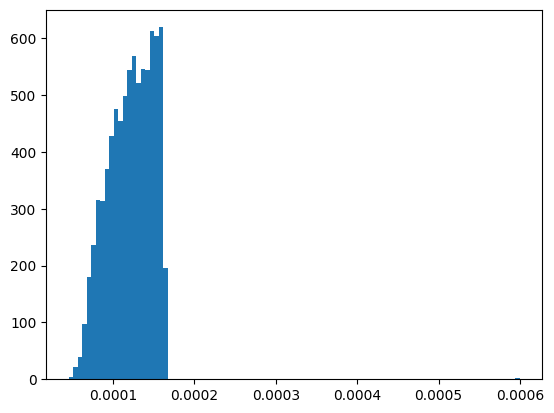

In [35]:
import torch
import math
import matplotlib.pyplot as plt

def get_class_weight_vector(tokenizer: Tokenizer, smoothing: float=0.5) -> torch.Tensor:
    num_of_class = len(tokenizer)
    weight_vector = torch.ones(num_of_class, dtype=torch.float)
    
    for word, count in tokenizer.counter.items():
        idx = tokenizer.to_idx(word)
        # min_count = 1e-6 # to prevent zero division
        # weight_vector[idx] = 1.0 / ((count + min_count) ** smoothing) # Power
        weight_vector[idx] = 1.0 / math.log(count + math.e)
    
    return weight_vector / weight_vector.sum() # normalize weight

weight_vector = get_class_weight_vector(doc_tokenizer)
plt.hist(weight_vector.numpy(), bins=100)